# Parameters for the Gaussian Kernel

The Gaussian kernel is often used as a smoothing filter. Because it is a lowpass kernel that is an eigenfunction under the Fourier transform, it lowpass filters without introducing ripple in either the time domain or the frequency domain. In `voicechat-modem-dsp`, we use Gaussian smoothing to remove high-frequency components from the datastream and to prevent ringing in the lowpass reconstruction.

In [1]:
import numpy as np
from scipy import signal
from scipy.stats import norm

In [2]:
%load_ext itikz

The typical window size for a Gaussian kernel is $6\sigma+1$ for integer $\sigma$, so we generalize this for all positive $\sigma$ as shown below (making sure that $w$ remains odd to avoid scalloping):

$$
w=
\begin{cases}
\lceil 6\sigma+1 \rceil & \lceil 6\sigma+1 \rceil \equiv 1 \bmod 2 \\
\lceil 6\sigma+1 \rceil + 1 & \lceil 6\sigma+1 \rceil \equiv 0 \bmod 2
\end{cases}
$$

In [3]:
"""
Computes a gaussian smoothing filter given sampling rate and sigma time
"""
def gaussian_window(fs, sigma_dt):
    sigma=sigma_dt*fs
    sample_count=np.ceil(6*sigma+1)
    if sample_count%2==0:
        sample_count+=1
    raw_window=signal.windows.gaussian(sample_count, sigma)
    raw_window_sum=np.sum(raw_window)
    return raw_window/raw_window_sum

There are two criteria that we use to calculate the sigma and prevent intersymbol interference: the time-domain criterion and the frequency-domain criterion.

## Time-Domain Criterion

Given a pulse with a width, we want to ensure that the total portion of the transition significantly affected by smoothing is at most half the pulse width.

To more precisely define "significantly affected", we define a threshold such that, for a transition from extremes, the filtered pulse settles on the final value close enough to be unambiguously different from the neighboring symbols. We assume 256 distinct, evenly spaced symbols, leaving a band of $s\pm\frac{1}{512}$ in which a symbol can be recognized unambiguously.

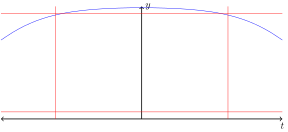

In [4]:
%%itikz --temp-dir
\documentclass[tikz]{standalone}
% Source: https://tex.stackexchange.com/questions/60950/how-to-draw-cdf-of-normal-distribution-in-tikz
\tikzset{
    declare function={
        %normcdf(\x,\m,\s)=1/(1 + exp(-0.07056*((\x-\m)/\s)^3 - 1.5976*(\x-\m)/\s));
        normcdf(\x,\m,\s)=1/(1 + exp(-1.702*((\x-\m)/\s) ));
    }
}
\def\sigmaval{2}
\def\vertlineval{(1.534*\sigmaval)}
\begin{document}
\begin{tikzpicture}

\draw[thick,<->] (-5,0) -- (5,0) coordinate [label={below: $t$}] (xmax);
\draw[thick,->] (0,0) -- (0,4) coordinate [label={right: $y$}] (ymax);

\draw[blue,domain=-5:5,smooth,variable=\x] plot ({\x},{4*(normcdf(\x+6,0,\sigmaval)-normcdf(\x-6,0,\sigmaval))});
\draw[red] ({-\vertlineval},0) -- ({-\vertlineval},4);
\draw[red] ({\vertlineval},0) -- ({\vertlineval},4);
\draw[red] (-5,4/16) -- (5,4/16);
\draw[red] (-5,4-4/16) -- (5,4-4/16);
\end{tikzpicture}
\end{document}

The usable segment $l=\frac{w}{2}$ of the pulse is $w-2k_t \sigma_t$. Solving for $\sigma_t$ gives

\begin{align*}
\frac{w}{2}&=w-2k_t \sigma_t \\
\frac{w}{2}&=2k_t \sigma_t \\
\sigma_t&=\frac{w}{4k_t}
\end{align*}

Since the convolution of a Gaussian kernel with the step function is the CDF of the kernel, we wish to find the $z$-value $k_t$ such that $1-\Phi^{-1}(k_t)=\frac{1}{512}$:

In [5]:
norm.isf(1/512) #Inverse survival function, where survival function=1-cdf

2.8856349124267573

## Frequency-Domain Criterion

When the baud is small enough, we would like to reduce the size of the Gaussian kernel without adversely impacting signal integrity. To ensure this, we turn to the frequency domain: since we want to filter out the $2\omega_c$ components when doing product demodulation, we ensure that the Gaussian filter sufficiently rejects components above $\omega_c$. (Half the demodulated carrier is not always the original carrier due to Nyquist aliasing, but we ignore that here for simplicity.)

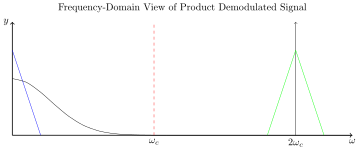

In [6]:
%%itikz --temp-dir
\documentclass[tikz]{standalone}
\begin{document}
\def\omegaval{5}
\def\sigmaval{(5/3.719)}
\def\sidebandwidth{1}
\begin{tikzpicture}
%Axes
\node[align=center] at (6,4.5) {Frequency-Domain View of Product Demodulated Signal};
\draw[thick, ->] (0,0) -- (12,0) coordinate [label={below: $\omega$}] (xmax);
\draw[thick, ->] (0,0) -- (0,4) coordinate [label={left: $y$}] (ymax);

%Frequency labels
\coordinate[label={below:$\omega_c$}] (w_c) at (\omegaval,0) {};
\coordinate[label={below:$2\omega_c$}] (two_w_c) at (2*\omegaval,0) {};

%omega_c and related vertical lines
\draw[red, dashed] (\omegaval,0) -- (\omegaval,4);
\draw[->] (2*\omegaval,0) -- (2*\omegaval,4);

% Demodulated signal components
\draw[blue] (0,3) -- (\sidebandwidth,0);
\draw[green] (2*\omegaval,3) -- (2*\omegaval-\sidebandwidth,0);
\draw[green] (2*\omegaval,3) -- (2*\omegaval+\sidebandwidth,0);

\draw[domain=0:12,smooth,variable=\x] plot ({\x},{2*e^(-0.5*(\x/\sigmaval)^2)});
\end{tikzpicture}
\end{document}

Since $\sigma_f=\frac{\omega_c}{k_f}$ and $\sigma_t=\frac{1}{2 \pi \sigma_f}$, we get $\sigma_t=\frac{k_f}{2 \pi \omega_c}$.

We can use an -80dB rejection threshold to find a corresponding $z$-value $k_f$ such that $1-\Phi^{-1}(k_f)=0.0001$:

In [7]:
norm.isf(0.0001)

3.7190164854556804

## Conclusion

We use these two criteria to calculate an appropriate $\sigma$ value for the Gaussian kernel. We take the minimum of these two in order to ensure sufficient smoothing while preventing the kernel from growing too large.